In [496]:
import pandas as pd
from pymongo import MongoClient

In [497]:
def _connect_mongo(host, port, username, password, db):
    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)
    return conn[db]

In [498]:
def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    cursor = db[collection].find(query)
    df =  pd.DataFrame(list(cursor))
    if no_id:
        del df['_id']
    return df

In [499]:
df=read_mongo('Spotify', 'Api_data')  
df

,,Artist Name,Genres,Popularity,Followers Count
0,0,Dakpa Nepali,singing bowl,38,1404
1,1,Swoopna Suman,nepali pop,46,193318
2,2,Sajjan Raj Vaidya,nepali pop,53,504272
3,3,Trishna Gurung,nepali pop,39,61402
4,4,Melina Rai,nepali pop,43,61665
...,...,...,...,...,...
495,495,Arjun Kaushal,cover artist,9,111
496,496,Sashan Kandel,cover artist,5,142
497,497,Nirmala Bhandari,cover artist,8,41
498,498,Uday Raj Poudel,nepali indie,5,90


In [500]:
df.columns

Index(['', 'Artist Name', 'Genres', 'Popularity', 'Followers Count'], dtype='object')

In [501]:
df['Genres'].value_counts()

cover artist         221
nepali pop           204
lok dohori            17
rap                   14
nepali indie          13
modern classical       8
nepali rock            8
himalayan folk         6
music distributor      5
folk rock              2
singing bowl           1
hard rock              1
Name: Genres, dtype: int64

In [502]:
df['genres_type']=df['Genres'].replace({'cover artist':1,'nepali pop':2,'lok dohori':3,'rap':4,'nepali indie':5,          
'modern classical':6,'nepali rock':7,'himalayan folk':8,'music distributor':9,'folk rock':10,'singing bowl':11,
'hard rock':12})
df.head()


,,Artist Name,Genres,Popularity,Followers Count,genres_type
0,0,Dakpa Nepali,singing bowl,38,1404,11
1,1,Swoopna Suman,nepali pop,46,193318,2
2,2,Sajjan Raj Vaidya,nepali pop,53,504272,2
3,3,Trishna Gurung,nepali pop,39,61402,2
4,4,Melina Rai,nepali pop,43,61665,2


In [503]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot: xlabel='Followers Count', ylabel='Genres'>

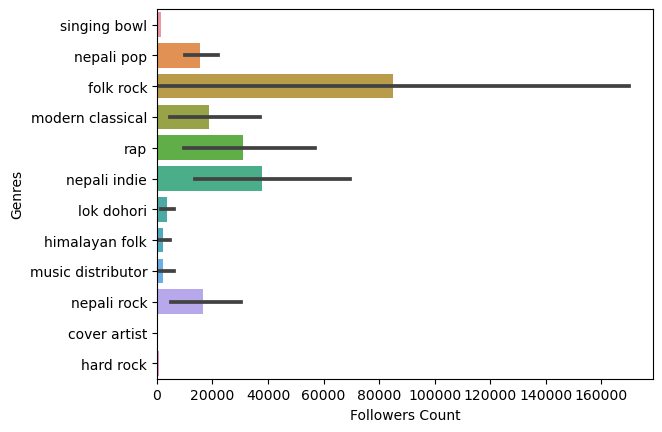

In [504]:
sns.barplot(y='Genres',x='Followers Count',data=df)

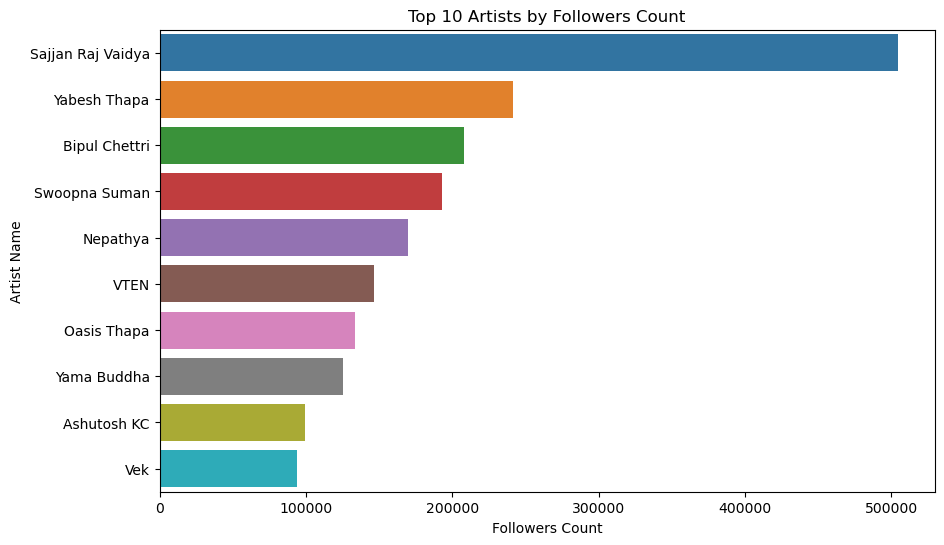

In [505]:
top_10_artists = df.sort_values(by='Followers Count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y='Artist Name', x='Followers Count', data=top_10_artists)
plt.title('Top 10 Artists by Followers Count')
plt.xlabel('Followers Count')
plt.ylabel('Artist Name')
plt.show()

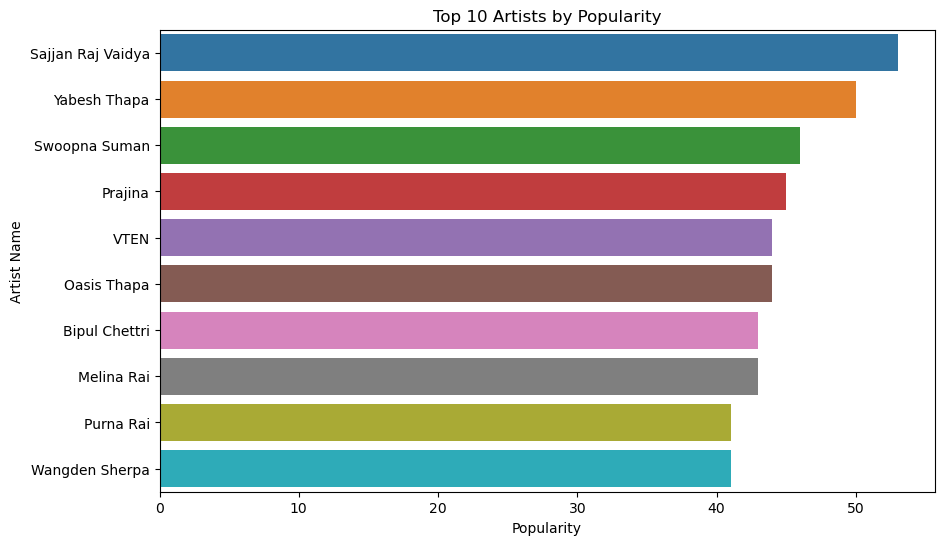

In [506]:
top_10_artists = df.sort_values(by='Popularity', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y='Artist Name', x='Popularity', data=top_10_artists)
plt.title('Top 10 Artists by Popularity')
plt.xlabel('Popularity')
plt.ylabel('Artist Name')
plt.show()

In [507]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [508]:
x=df[['Followers Count','Popularity']]
y=df['Artist Name']

In [509]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model=RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

In [510]:
X_train.shape

(400, 2)

In [511]:
y_train.shape

(400,)

In [512]:
y_pred=model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
classification_report=classification_report(y_test,y_pred)

In [513]:
sample=[[240000,98]]
y_pred=model.predict(sample)
print("The genre is",y_pred)

The genre is ['Swoopna Suman']


In [514]:
import pickle
with open('predict_artist.pkl','wb') as f:
    pickle.dump(model,f)

In [515]:
import pickle


def recommend_similar_artists(artist_name, df, top_n=3):
    artist_name = artist_name.lower()
    
    matching_artists = df[df['Artist Name'].str.lower().str.contains(artist_name)]
    
    if len(matching_artists) == 0:
        print("No artist found with a similar name.")
        return
    input_artist_info = matching_artists.iloc[0]
    
    input_genre = input_artist_info['genres_type']
    
    similar_genre_artists = df[df['genres_type'] == input_genre]
    
    similar_genre_artists = similar_genre_artists[similar_genre_artists['Artist Name'].str.lower() != artist_name]
    
    similar_artists = similar_genre_artists.head(top_n)
    
    return similar_artists

with open("predict_similar_artist.pkl", "wb") as f:
    pickle.dump(recommend_similar_artists, f)
